# Convert XML to MLLM input

In [4]:
import os
import json
from util import xml_to_mllm_converter, draw_group_boxes, draw_element_boxes

read_xml_path = '/home/jjseol/jjseol/data/Mordor_validation_66/xml_sheets/21231.xml'
read_img_path = '/home/jjseol/jjseol/data/Mordor_validation_66/thumbnails/21231.png'

mllm = xml_to_mllm_converter(read_xml_path,read_img_path)

mllm

{'messages': [{'content': '<image> {"TEXT_1": {"tag": "TEXT", "text_content": "페이지 제목", "tbpe_id": "TEXT_1", "x": 200, "y": 261, "w": 1520, "h": 89, "priority": "0"}, "TEXT_2": {"tag": "TEXT", "text_content": "부제목을 입력해주세요", "tbpe_id": "TEXT_2", "x": 200, "y": 200, "w": 1520, "h": 38, "priority": "1"}, "SHAPESVG_1": {"tag": "SHAPESVG", "text_content": "None", "tbpe_id": "SHAPESVG_1", "x": 200, "y": 645, "w": 217, "h": 40, "priority": "2"}, "LineShapeItem_1": {"tag": "LineShapeItem", "text_content": "None", "tbpe_id": "LineShapeItem_1", "x": 277, "y": 613, "w": 64, "h": 7, "priority": "3"}, "TEXT_3": {"tag": "TEXT", "text_content": "메시지는 짧고 간결할수록 효과적으로 전달돼요.", "tbpe_id": "TEXT_3", "x": 200, "y": 502, "w": 217, "h": 58, "priority": "4"}, "TEXT_4": {"tag": "TEXT", "text_content": "1단계", "tbpe_id": "TEXT_4", "x": 200, "y": 449, "w": 217, "h": 37, "priority": "5"}, "SHAPESVG_2": {"tag": "SHAPESVG", "text_content": "None", "tbpe_id": "SHAPESVG_2", "x": 417, "y": 645, "w": 217, "h": 40, "prior

# Generating Group

In [ ]:

import gc
import json
import os
from typing import Optional
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  
import fire
from tqdm import tqdm
from transformers import Seq2SeqTrainingArguments

from llamafactory.data import get_dataset, get_template_and_fix_tokenizer
from llamafactory.extras.constants import IGNORE_INDEX
from llamafactory.extras.misc import get_device_count
from llamafactory.extras.packages import is_vllm_available
from llamafactory.hparams import get_infer_args
from llamafactory.model import load_tokenizer, load_model

from util import xml_to_mllm_converter, draw_group_boxes, draw_element_boxes, clean_and_parse_json

if is_vllm_available():
    from vllm import LLM, SamplingParams
    from vllm.lora.request import LoRARequest

import torch
from PIL import Image


model_name_or_path = "Qwen/Qwen2.5-VL-3B-Instruct" 
adapter_name_or_path = "saves/qwen2_5vl-3b/lora/sft"
dataset = "mllm_eval_dataset"
dataset_dir = "data"
template = "qwen2_vl"
cutoff_len = 15000
max_samples = None
vllm_config = "{}"
save_name = "generated_predictions.jsonl"
temperature = 0.95
top_p = 0.7
top_k = 50
max_new_tokens = 100000
repetition_penalty = 1.0
skip_special_tokens = True
default_system = None
enable_thinking = True
seed = None
pipeline_parallel_size = 1
image_max_pixels = 262144
image_min_pixels = 32 * 32
video_fps = 2.0
video_maxlen = 128
batch_size = 1024

model_args, data_args, finetuning_args, generating_args = get_infer_args(
    dict(
        model_name_or_path=model_name_or_path,
        adapter_name_or_path=adapter_name_or_path,
        dataset=dataset,
        dataset_dir=dataset_dir,
        template=template,
        cutoff_len=cutoff_len,
        max_samples=max_samples,
        preprocessing_num_workers=16,
        default_system=default_system,
        enable_thinking=enable_thinking,
        vllm_config=vllm_config,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        max_new_tokens=max_new_tokens,
        repetition_penalty=repetition_penalty,
    )
)
training_args = Seq2SeqTrainingArguments(output_dir="dummy_dir")
tokenizer_module = load_tokenizer(model_args)
tokenizer = tokenizer_module["tokenizer"]
template_obj = get_template_and_fix_tokenizer(tokenizer, data_args)
template_obj.mm_plugin.expand_mm_tokens = False
engine_args = {
    "model": model_args.model_name_or_path,
    "trust_remote_code": True,
    "dtype": model_args.infer_dtype,
    "max_model_len": cutoff_len + max_new_tokens,
    "gpu_memory_utilization": 0.2,#model_args.vllm_gpu_util,
    "tensor_parallel_size": (get_device_count() // pipeline_parallel_size) or 1,
    "pipeline_parallel_size": pipeline_parallel_size,
    "disable_log_stats": True,
    "enable_lora": model_args.adapter_name_or_path is not None,
}
if template_obj.mm_plugin.__class__.__name__ != "BasePlugin":
    engine_args["limit_mm_per_prompt"] = {"image": 4, "video": 2, "audio": 2}
if isinstance(model_args.vllm_config, dict):
    engine_args.update(model_args.vllm_config)
from llamafactory.model import load_model, load_tokenizer


tokenizer_module = load_tokenizer(model_args)

tokenizer = tokenizer_module["tokenizer"]

#model = load_model(tokenizer, model_args, finetuning_args)
llm = LLM(**engine_args)
if model_args.adapter_name_or_path is not None:
    lora_request = LoRARequest("default", 1, model_args.adapter_name_or_path[0])
else:
    lora_request = None
#dataset_module = get_dataset(template_obj, model_args, data_args, training_args, "ppo", **tokenizer_module)
#train_dataset = dataset_module["train_dataset"]
sampling_params = SamplingParams(
    repetition_penalty=generating_args.repetition_penalty or 1.0,  # repetition_penalty must > 0
    temperature=0, #generating_args.temperature,
    top_p=generating_args.top_p or 1.0,  # top_p must > 0
    top_k=generating_args.top_k or -1,  # top_k must > 0
    stop_token_ids=template_obj.get_stop_token_ids(tokenizer),
    max_tokens=15000,#generating_args.max_new_tokens,
    skip_special_tokens=skip_special_tokens,
    seed=seed,
)

/home/jjseol/miniconda3/envs/LLaMA-Factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 07-09 18:39:04 [__init__.py:244] Automatically detected platform cuda.


2025-07-09 18:39:06,492	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[INFO|training_args.py:2135] 2025-07-09 18:39:06,512 >> PyTorch: setting up devices
[INFO|training_args.py:1812] 2025-07-09 18:39:06,637 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:07,087 >> loading file vocab.json from cache at /home/jjseol/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-3B-Instruct/snapshots/66285546d2b821cf421d4f5eb2576359d3770cd3/vocab.json
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:07,088 >> loading file merges.txt from cache at /home/jjseol/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-3B-Instruct/snapsh

INFO 07-09 18:39:26 [config.py:823] This model supports multiple tasks: {'reward', 'embed', 'score', 'generate', 'classify'}. Defaulting to 'generate'.
INFO 07-09 18:39:27 [config.py:2195] Chunked prefill is enabled with max_num_batched_tokens=8192.


[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:28,916 >> loading file vocab.json from cache at /home/jjseol/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-3B-Instruct/snapshots/66285546d2b821cf421d4f5eb2576359d3770cd3/vocab.json
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:28,918 >> loading file merges.txt from cache at /home/jjseol/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-3B-Instruct/snapshots/66285546d2b821cf421d4f5eb2576359d3770cd3/merges.txt
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:28,919 >> loading file tokenizer.json from cache at /home/jjseol/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-3B-Instruct/snapshots/66285546d2b821cf421d4f5eb2576359d3770cd3/tokenizer.json
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:28,920 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2023] 2025-07-09 18:39:28,920 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:2023

WARNING 07-09 18:39:29 [utils.py:2597] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
WARNING 07-09 18:39:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 07-09 18:39:33 [__init__.py:244] Automatically detected platform cuda.
INFO 07-09 18:39:38 [core.py:455] Waiting for init message from front-end.
INFO 07-09 18:39:38 [core.py:70] Initializing a V1 LLM engine (v0.9.1) with config: model='Qwen/Qwen2.5-VL-3B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-VL-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=115000, down

[W709 18:39:49.034198443 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3
[W709 18:39:59.045764942 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


INFO 07-09 18:39:59 [parallel_state.py:1065] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Unused or unrecognized kwargs: fps, return_tensors.


WARNING 07-09 18:40:22 [topk_topp_sampler.py:59] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
INFO 07-09 18:40:22 [gpu_model_runner.py:1595] Starting to load model Qwen/Qwen2.5-VL-3B-Instruct...
INFO 07-09 18:40:23 [gpu_model_runner.py:1600] Loading model from scratch...
WARNING 07-09 18:40:23 [vision.py:91] Current `vllm-flash-attn` has a bug inside vision module, so we use xformers backend instead. You can run `pip install flash-attn` to use flash-attention backend.
INFO 07-09 18:40:23 [cuda.py:252] Using Flash Attention backend on V1 engine.
INFO 07-09 18:40:23 [weight_utils.py:292] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.82it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.54it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.58it/s]



INFO 07-09 18:40:25 [default_loader.py:272] Loading weights took 1.44 seconds
WARNING 07-09 18:40:25 [lora_model_runner_mixin.py:37] Regarding multimodal models, vLLM currently only supports adding LoRA to language model.
INFO 07-09 18:40:25 [punica_selector.py:19] Using PunicaWrapperGPU.
WARNING 07-09 18:40:25 [models.py:496] Regarding multimodal models, vLLM currently only supports adding LoRA to language model, visual.patch_embed.proj will be ignored.
WARNING 07-09 18:40:25 [models.py:496] Regarding multimodal models, vLLM currently only supports adding LoRA to language model, visual.blocks.0 will be ignored.
WARNING 07-09 18:40:25 [models.py:496] Regarding multimodal models, vLLM currently only supports adding LoRA to language model, visual.blocks.0.attn.qkv will be ignored.
WARNING 07-09 18:40:25 [models.py:496] Regarding multimodal models, vLLM currently only supports adding LoRA to language model, visual.blocks.0.attn.proj will be ignored.
WARNING 07-09 18:40:25 [models.py:496] 

Unused or unrecognized kwargs: fps, return_tensors.


INFO 07-09 18:40:57 [backends.py:462] Using cache directory: /home/jjseol/.cache/vllm/torch_compile_cache/af81b44ffd/rank_0_0 for vLLM's torch.compile
INFO 07-09 18:40:57 [backends.py:472] Dynamo bytecode transform time: 11.14 s
INFO 07-09 18:41:05 [backends.py:135] Directly load the compiled graph(s) for shape None from the cache, took 7.348 s
INFO 07-09 18:41:07 [monitor.py:34] torch.compile takes 11.14 s in total
INFO 07-09 18:41:07 [gpu_worker.py:227] Available KV cache memory: 5.73 GiB
INFO 07-09 18:41:08 [kv_cache_utils.py:715] GPU KV cache size: 166,944 tokens
INFO 07-09 18:41:08 [kv_cache_utils.py:719] Maximum concurrency for 115,000 tokens per request: 1.45x
INFO 07-09 18:41:58 [gpu_model_runner.py:2048] Graph capturing finished in 50 secs, took 0.82 GiB
INFO 07-09 18:41:58 [core.py:171] init engine (profile, create kv cache, warmup model) took 92.53 seconds


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it, est. speed input: 507.33 toks/s, output: 89.23 toks/s]


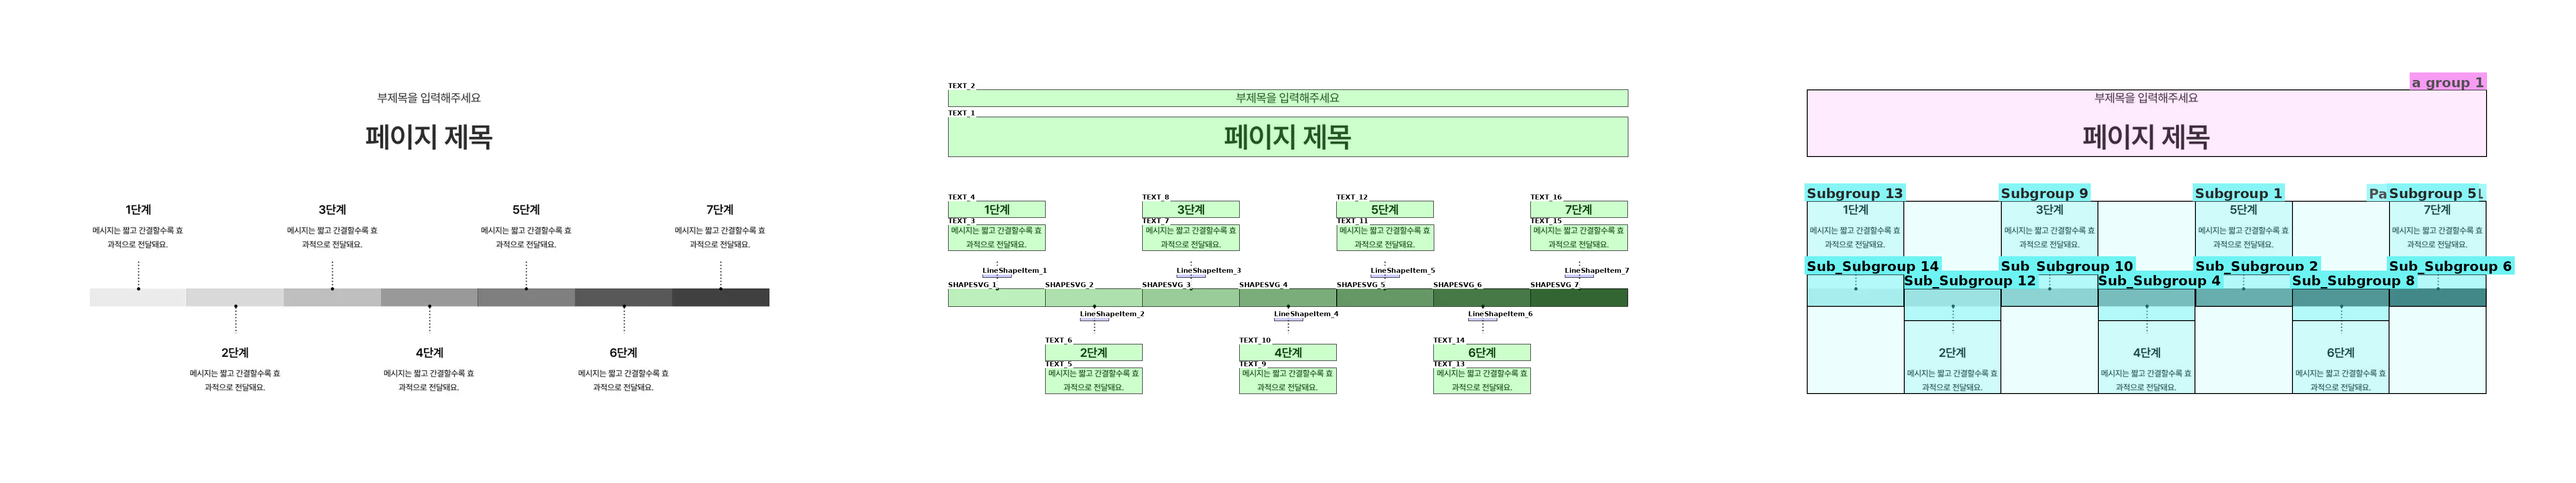

In [ ]:
read_xml_path = '/home/jjseol/jjseol/data/Mordor_validation_66/xml_sheets/21231.xml'
read_img_path = '/home/jjseol/jjseol/data/Mordor_validation_66/thumbnails/21231.png'


# input data processing
mllm_dataset = xml_to_mllm_converter(read_xml_path,read_img_path)

messages = mllm_dataset['messages']
images = mllm_dataset['images']
messages = template_obj.mm_plugin.process_messages(messages, images or [], [],[], tokenizer_module['processor'])
prompt_ids,_ = template_obj.encode_oneturn(tokenizer, messages, None, None)
prompt_length = len(prompt_ids)
if images is not None:  # add image features
     multi_modal_data = {
         "image": template_obj.mm_plugin._regularize_images(
             images,image_max_pixels=image_max_pixels, image_min_pixels=image_min_pixels
         )["images"]
         }

# generate response
result = llm.generate(
    {"prompt_token_ids": prompt_ids, "multi_modal_data": multi_modal_data},
    sampling_params=sampling_params,
    lora_request=lora_request,
)

data = json.loads(json.dumps({"prompt":tokenizer.decode(prompt_ids,skip_special_tokens=True), "predict" : result[0].outputs[0].text, "label":[], "image": images}, ensure_ascii=False))

# visualzation
prompt_text = data['prompt'].split("user\n ")[1]
prompt_dict = clean_and_parse_json(prompt_text)
predict_dict = json.loads(data['predict'])

image = Image.open(data['image'][0]).resize((1920,1080))
drawed_element_img = draw_element_boxes(image,prompt_dict)
drawed_group_box = draw_group_boxes(image,predict_dict,prompt_dict)
total_width = image.width*3
new_img = Image.new('RGB', (total_width, image.height), (255, 255, 255))
x_offset = 0
for img in [image, drawed_element_img, drawed_group_box]:
    new_img.paste(img, (x_offset, 0))
    x_offset += img.width


display(new_img)